<a href="https://colab.research.google.com/github/vsbca/Data-Science/blob/master/Mitre_TTPs_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Agenda**
1. Quick Mitre Introduction
2. Mitre Mappingin Logs

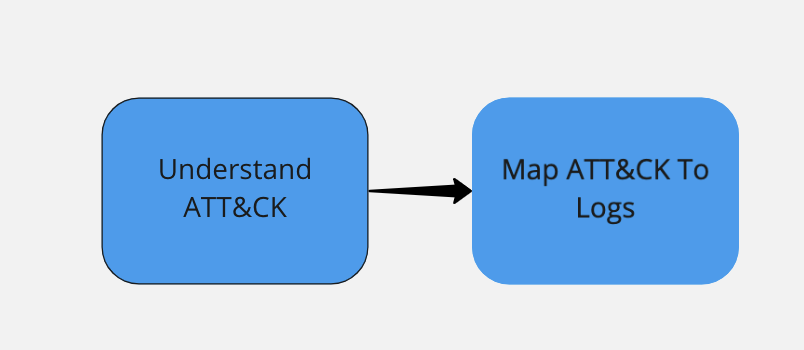


In [ ]:
!pip install attackcti

In [ ]:
!pip install altair

In [ ]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
import numpy as np
import sys
from pandas.io.json import json_normalize
from attackcti import attack_client

import altair as alt
alt.renderers.enable('default')
import itertools


In [ ]:
att_ck = attack_client()

In [ ]:
all_ttps = att_ck.get_enterprise_techniques(stix_format=False)

In [ ]:
all_ttps[0]

{'created': '2020-10-20T00:09:33.072Z',
 'created_by_ref': 'identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5',
 'data_sources': ['Network device logs',
  'Network device run-time memory',
  'Network device command history',
  'Network device configuration'],
 'external_references': [{'external_id': 'T1059.008',
   'source_name': 'mitre-attack',
   'url': 'https://attack.mitre.org/techniques/T1059/008'},
  {'description': 'Graham Holmes. (2015, October 8). Evolution of attacks on Cisco IOS devices. Retrieved October 19, 2020.',
   'source_name': 'Cisco Synful Knock Evolution',
   'url': 'https://blogs.cisco.com/security/evolution-of-attacks-on-cisco-ios-devices'},
  {'description': 'Cisco. (n.d.). Cisco IOS Software Integrity Assurance - Command History. Retrieved October 21, 2020.',
   'source_name': 'Cisco IOS Software Integrity Assurance - Command History',
   'url': 'https://tools.cisco.com/security/center/resources/integrity_assurance.html#23'}],
 'id': 'attack-pattern--818302b2-d640

In [ ]:
#Normalize
ttp_normalized = json_normalize(all_ttps)
ttp_normalized[0:1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,external_references,kill_chain_phases,x_mitre_is_subtechnique,x_mitre_version,id,technique_description,technique,created_by_ref,object_marking_refs,url,matrix,technique_id,type,tactic,modified,created,data_sources,platform,technique_detection,permissions_required,defense_bypassed,capec_id,capec_url,contributors,system_requirements,network_requirements,effective_permissions,remote_support,impact_type,revoked,x_mitre_deprecated
0,"[{'source_name': 'mitre-attack', 'external_id'...","[{'kill_chain_name': 'mitre-attack', 'phase_na...",True,1.0,attack-pattern--818302b2-d640-477b-bf88-873120...,Adversaries may abuse scripting or built-in co...,Network Device CLI,identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5,[marking-definition--fa42a846-8d90-4e51-bc29-7...,https://attack.mitre.org/techniques/T1059/008,mitre-attack,T1059.008,attack-pattern,[execution],2020-10-22T16:43:38.388Z,2020-10-20T00:09:33.072Z,"[Network device logs, Network device run-time ...",[Network],Consider reviewing command history in either t...,"[Administrator, User]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Re-Indexing the Dataframe
techniques = ttp_normalized.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

In [ ]:
techniques.head(3)

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,[Network],[execution],Network Device CLI,T1059.008,"[Network device logs, Network device run-time ..."
1,mitre-attack,[Network],[collection],Network Device Configuration Dump,T1602.002,"[Netflow/Enclave netflow, Network protocol ana..."
2,mitre-attack,[Network],"[defense-evasion, persistence]",TFTP Boot,T1542.005,"[Network device run-time memory, Network devic..."


In [ ]:
#Total number of tecniques
print('Total of ',len(techniques),' techniques')

Total of  665  techniques


In [ ]:
#Group
data = techniques
data_2 = data.groupby(['matrix'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,technique
0,mitre-attack,665


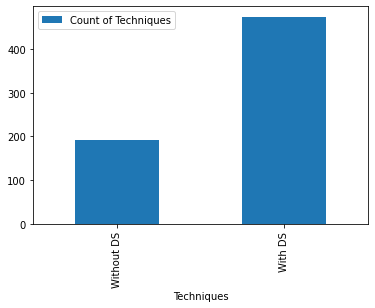

In [ ]:
#Techniques without DataSources

data_source_distribution = pd.DataFrame({
    'Techniques': ['Without DS','With DS'],
    'Count of Techniques': [techniques['data_sources'].isna().sum(),techniques['data_sources'].notna().sum()]})

#bars = alt.Chart(data_source_distribution).mark_bar().encode(x='Techniques',y='Count of Techniques',color='Techniques').properties(width=200,height=300)
#text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
#bars + text
import matplotlib.pyplot as plt
data_source_distribution.plot(kind="bar", x=  'Techniques', y = 'Count of Techniques')
plt.show()

In [ ]:
#Count
data = techniques
data['Count_DS'] = data['data_sources'].str.len()
data['Ind_DS'] = np.where(data['Count_DS']>0,'With DS','Without DS')
data_2 = data.groupby(['matrix','Ind_DS'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,Ind_DS,technique
0,mitre-attack,With DS,474
1,mitre-attack,Without DS,191


In [ ]:
#Techniques without datasource
techniques_without_data_sources=techniques[techniques.data_sources.isnull()].reset_index(drop=True)
techniques_without_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
0,mitre-attack,[PRE],[resource-development],Vulnerabilities,T1588.006,NaN,NaN,Without DS
1,mitre-attack,[PRE],[reconnaissance],Spearphishing Service,T1598.001,NaN,NaN,Without DS
2,mitre-attack,[PRE],[reconnaissance],Purchase Technical Data,T1597.002,NaN,NaN,Without DS
3,mitre-attack,[PRE],[reconnaissance],Threat Intel Vendors,T1597.001,NaN,NaN,Without DS
4,mitre-attack,[PRE],[reconnaissance],Search Closed Sources,T1597,NaN,NaN,Without DS


In [ ]:
print('There are ',techniques['data_sources'].isna().sum(),' techniques without data sources (',"{0:.0%}".format(techniques['data_sources'].isna().sum()/len(techniques)),' of ',len(techniques),' techniques)')

There are  191  techniques without data sources ( 29%  of  665  techniques)


In [ ]:
techniques_with_data_sources=techniques[techniques.data_sources.notnull()].reset_index(drop=True)

In [ ]:
techniques_with_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
0,mitre-attack,[Network],[execution],Network Device CLI,T1059.008,"[Network device logs, Network device run-time ...",4.0,With DS
1,mitre-attack,[Network],[collection],Network Device Configuration Dump,T1602.002,"[Netflow/Enclave netflow, Network protocol ana...",3.0,With DS
2,mitre-attack,[Network],"[defense-evasion, persistence]",TFTP Boot,T1542.005,"[Network device run-time memory, Network devic...",5.0,With DS
3,mitre-attack,[Network],"[defense-evasion, persistence]",ROMMONkit,T1542.004,"[File monitoring, Netflow/Enclave netflow, Net...",4.0,With DS
4,mitre-attack,[Network],[collection],SNMP (MIB Dump),T1602.001,"[Netflow/Enclave netflow, Network protocol ana...",3.0,With DS


In [ ]:
#Grouping Techniques With Data Sources by Platform
techniques_platform=techniques_with_data_sources

attributes_1 = ['platform'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_1:
    s = techniques_platform.apply(lambda x: pd.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_platform=techniques_platform.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_platform", and then join "techniques_platform" with "s"

# Let's re-arrange the columns from general to specific
techniques_platform_2=techniques_platform.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

In [ ]:
techniques_platform_2.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,Network,[execution],Network Device CLI,T1059.008,"[Network device logs, Network device run-time ..."
1,mitre-attack,Network,[collection],Network Device Configuration Dump,T1602.002,"[Netflow/Enclave netflow, Network protocol ana..."
2,mitre-attack,Network,"[defense-evasion, persistence]",TFTP Boot,T1542.005,"[Network device run-time memory, Network devic..."
3,mitre-attack,Network,"[defense-evasion, persistence]",ROMMONkit,T1542.004,"[File monitoring, Netflow/Enclave netflow, Net..."
4,mitre-attack,Network,[collection],SNMP (MIB Dump),T1602.001,"[Netflow/Enclave netflow, Network protocol ana..."


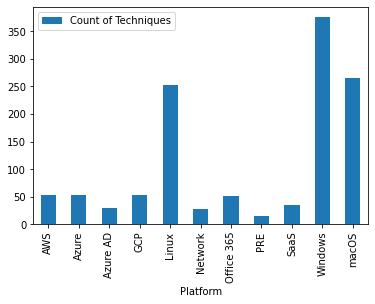

In [ ]:
#Let's create a visualization to show the number of techniques grouped by platform:
platform_distribution = pd.DataFrame({
    'Platform': list(techniques_platform_2.groupby(['platform'])['platform'].count().keys()),
    'Count of Techniques': techniques_platform_2.groupby(['platform'])['platform'].count().tolist()})

#Show in graph
platform_distribution.plot(kind="bar", x='Platform', y ='Count of Techniques')
plt.show()

In [ ]:
#Grouping techniques with Data Source
techniques_data_source=techniques_with_data_sources

attributes_3 = ['data_sources'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_3:
    s = techniques_data_source.apply(lambda x: pd.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_data_source = techniques_data_source.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_data_source", and then join "techniques_data_source" with "s"

# Let's re-arrange the columns from general to specific
techniques_data_source_2 = techniques_data_source.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

# We are going to edit some names inside the dataframe to improve the consistency:
techniques_data_source_3 = techniques_data_source_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])


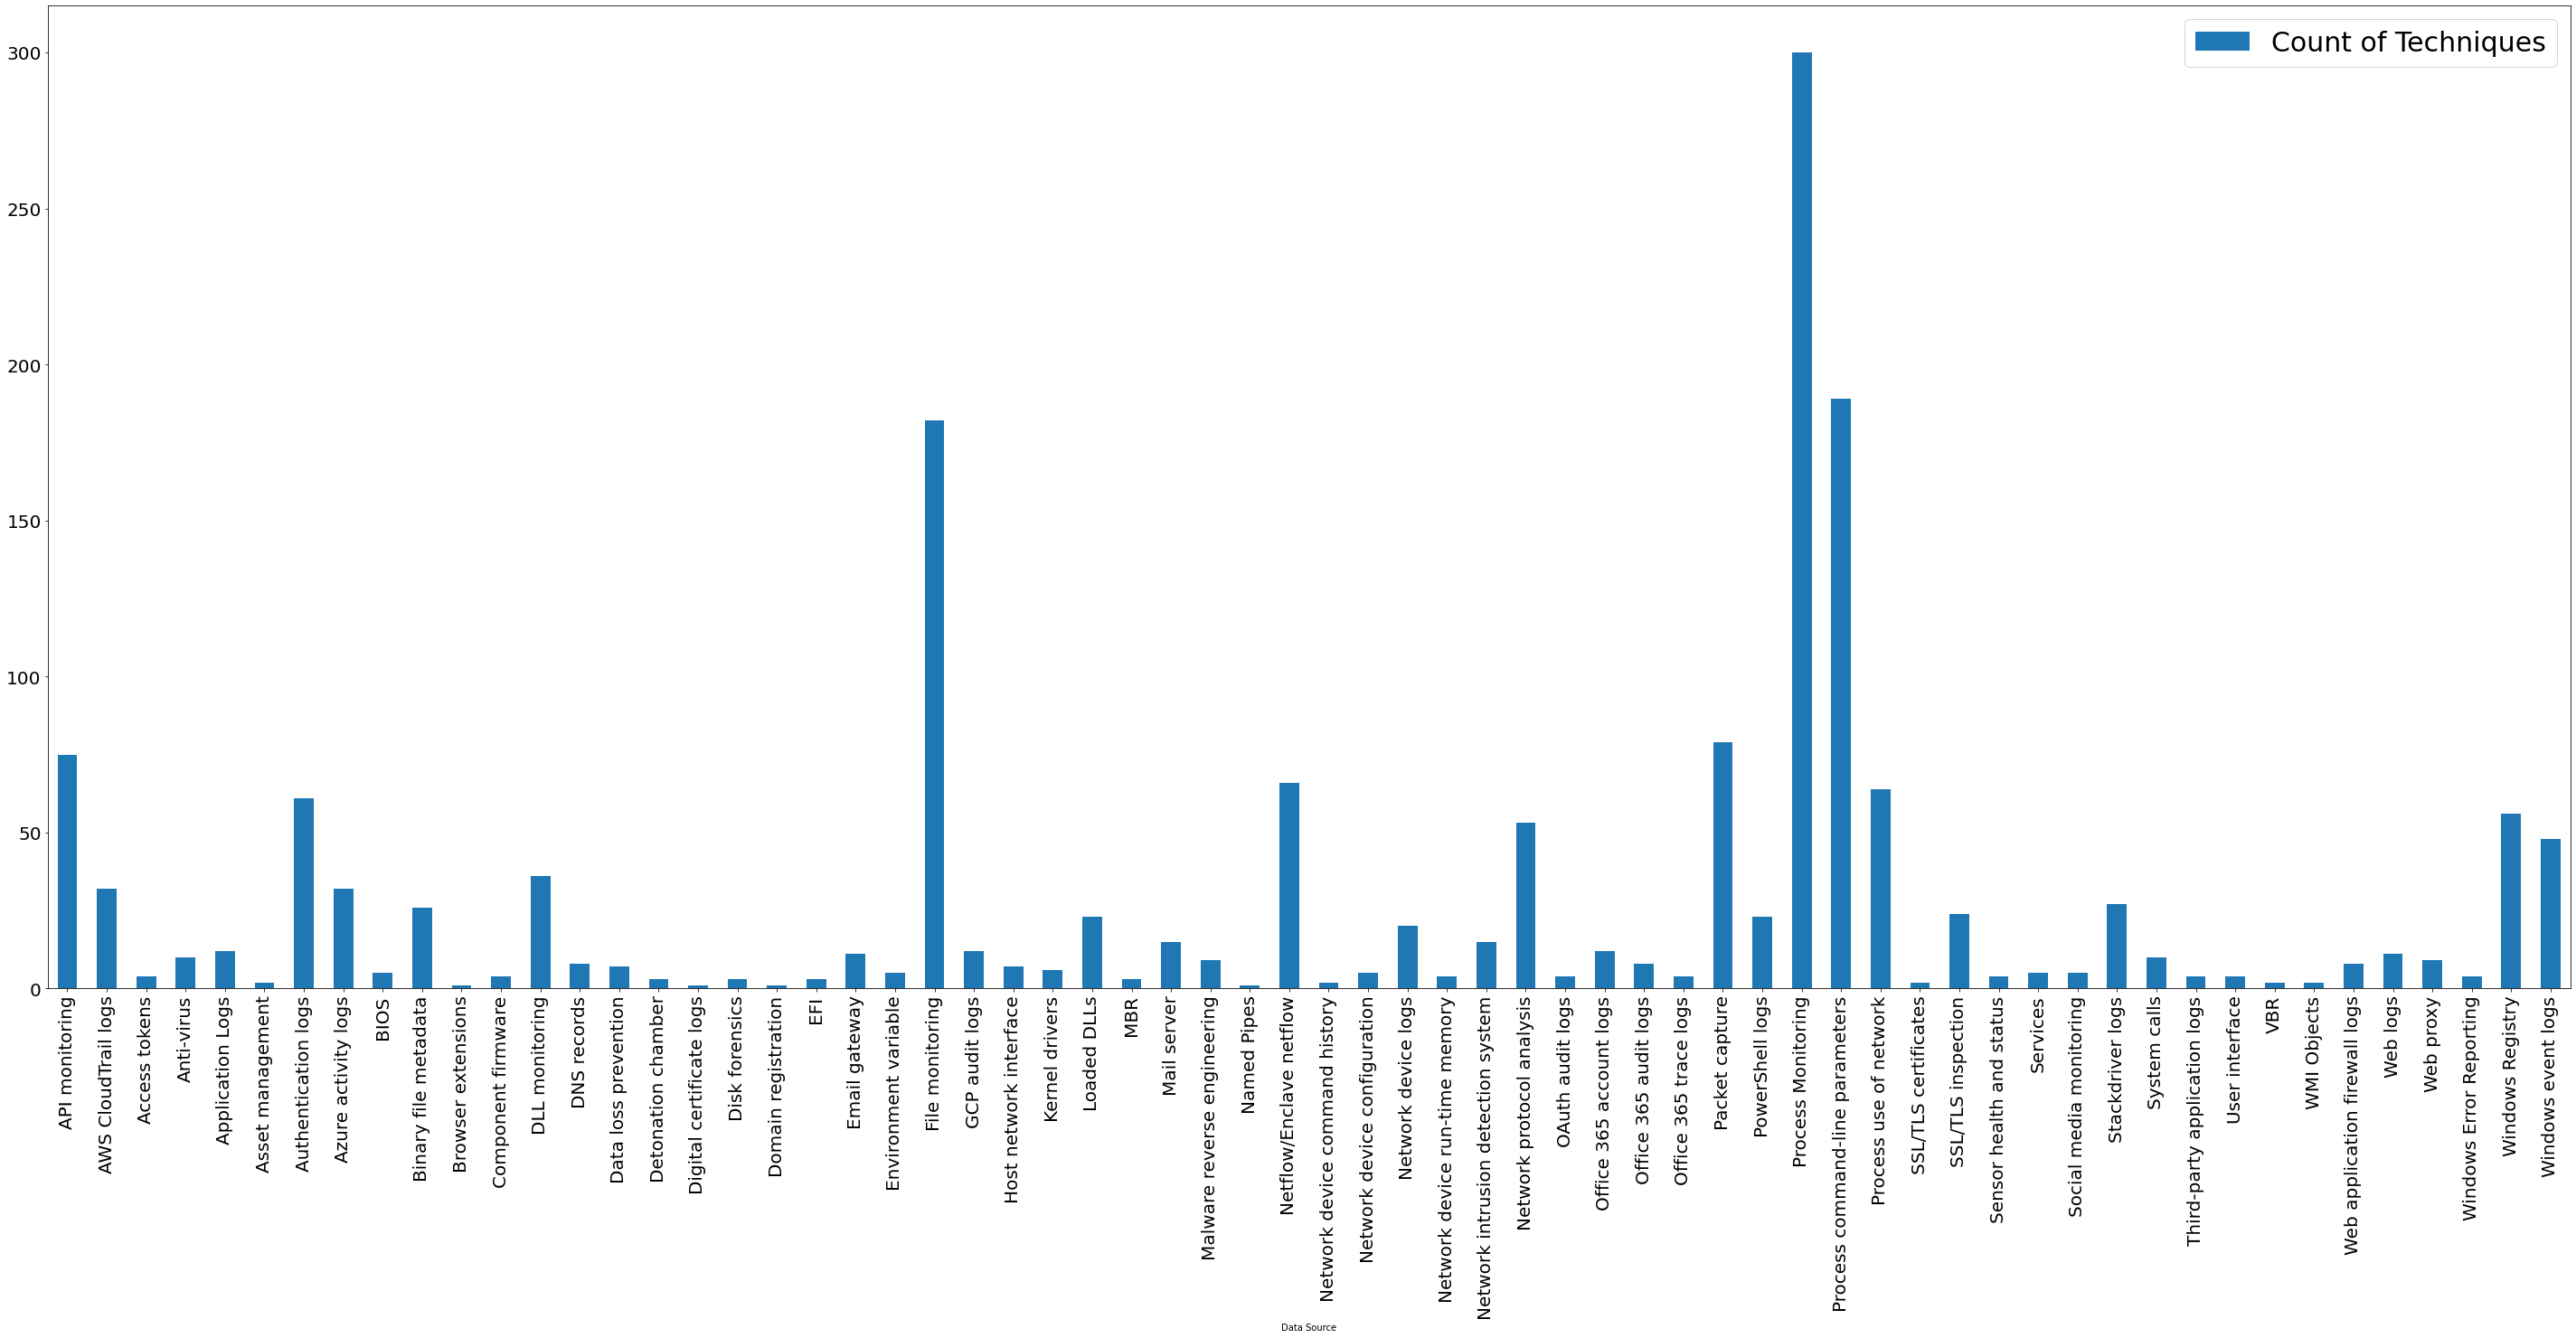

In [ ]:
#Show in Graphs

data_source_distribution = pd.DataFrame({
    'Data Source': list(techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().keys()),
    'Count of Techniques': techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().tolist()})


#Show in graph
data_source_distribution.plot(figsize=(50,20), kind="bar", x='Data Source', y ='Count of Techniques', fontsize=20).legend(fontsize=30)
plt.show()
